In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from PIL import Image
import glob, os
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import pickle
from os import listdir
from os.path import isfile, join
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_dir = './data/Kaggle/kaggle_train_128/train_128/'

# Training data
X_train = []
y_train = []
for i in range(5):
    subdir = train_dir + str(i) + '/'
    print(subdir)
    only_train_files = [f for f in listdir(subdir) if isfile(join(subdir, f))]  # all .png files
    for o_train in only_train_files:
        im_train = Image.open(subdir + o_train)
        X_train.append(np.array(im_train))
        im_train.close()
        y_train.append(i)

test_dir = './data/Kaggle/kaggle_test_128/test_128/'

# Test data
X_test = []
only_test_files = [g for g in listdir(test_dir) if isfile(join(test_dir, g))]  # all .png files
for o_test in only_test_files:
    im_test = Image.open(test_dir + o_test)
    X_test.append(np.array(im_test))
    im_test.close()

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

./data/Kaggle/kaggle_train_128/train_128/0/
./data/Kaggle/kaggle_train_128/train_128/1/
./data/Kaggle/kaggle_train_128/train_128/2/
./data/Kaggle/kaggle_train_128/train_128/3/
./data/Kaggle/kaggle_train_128/train_128/4/
(15000, 128, 128, 3)
(15000,)
(3500, 128, 128, 3)


In [3]:
X = X_train
y = y_train

# Split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image


In [4]:
print('Train data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)

Train data shape:  (12000, 128, 128, 3)
Training labels shape:  (12000,)
Validation data shape:  (3000, 128, 128, 3)
Validation labels shape:  (3000,)
Test data shape:  (3500, 128, 128, 3)
Train labels shape (one-hot):  (12000, 5)
Validation labels shape (one-hot):  (3000, 5)


In [5]:
#imports the mobilenet model and discards the last 1000 neuron layer.
base_model=MobileNet(weights='imagenet',include_top=False) 
# base_model=VGG16(weights='imagenet',include_top=False) 
# base_model=Xception(weights='imagenet',include_top=False) 
# base_model=VGG19(weights='imagenet',include_top=False) 
# base_model=InceptionV3(weights='imagenet',include_top=False) 
# base_model=InceptionResNetV2(weights='imagenet',include_top=False) 
# base_model=MobileNetV2(weights='imagenet',include_top=False) 
# base_model=NASNet(weights='imagenet',include_top=False) 


x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #dense layer 1
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dropout(0.2)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(5,activation='softmax')(x) #final layer with softmax activation

/home/ecbm4040/miniconda3/envs/envTF113/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model=Model(inputs=base_model.input,outputs=preds)

In [7]:
for layer in model.layers[:15]:
    layer.trainable=False
for layer in model.layers[15:]:
    layer.trainable=True

In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [9]:
bs= 16 
epc = 20 

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
train_generator = train_datagen.flow(X_train, y_train_dummy, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size

In [10]:
history = model.fit_generator(generator = train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = epc,
                   validation_data=(X_val, y_val_dummy))

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
750/750 [==============================] - 80s 107ms/step - loss: 0.4872 - acc: 0.8473 - val_loss: 1.4446 - val_acc: 0.6853
Epoch 2/20
750/750 [==============================] - 56s 74ms/step - loss: 0.2192 - acc: 0.9398 - val_loss: 1.1255 - val_acc: 0.7117
Epoch 3/20
750/750 [==============================] - 55s 74ms/step - loss: 0.1807 - acc: 0.9517 - val_loss: 0.7315 - val_acc: 0.7613
Epoch 4/20
750/750 [==============================] - 56s 74ms/step - loss: 0.1638 - acc: 0.9584 - val_loss: 0.9282 - val_acc: 0.6777
Epoch 5/20
750/750 [==============================] - 56s 75ms/step - loss: 0.1402 - acc: 0.9656 - val_loss: 0.9392 - val_acc: 0.6817
Epoch 6/20
750/750 [==============================] - 56s 74ms/step - loss: 0.1216 - acc: 0.9702 - val_loss: 0.9264 - val_acc: 0.7333
Epoch 7/20
750/750 [==============================] - 55s 74ms/step - loss: 0.1380 - acc: 0.9663 - val_loss: 1.6335 - val_acc: 0.7417
Epoch 8/20
75

In [11]:
print(f'Baseline accuracy: {model.evaluate(X_val, y_val_dummy)[1]}')

3000/3000 [==============================] - 4s 1ms/sample - loss: 1.2109 - acc: 0.6863
Baseline accuracy: 0.6863333582878113


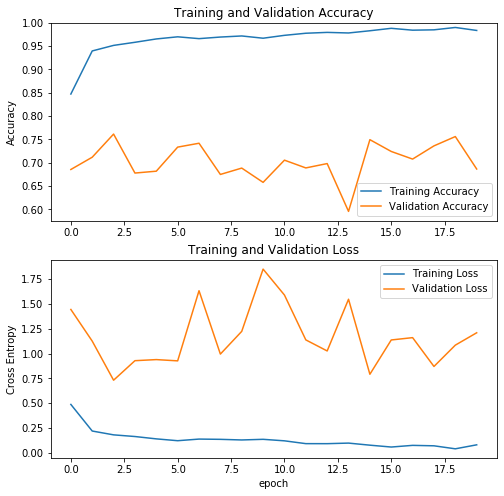

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
mean_image = np.mean(X_test, axis=0)

In [17]:
preds=model.predict(X_test)

In [18]:
dd = []
for i in range(preds.shape[0]):
    datum = preds[i]
    decoded_datum = np.argmax(preds[i])
    dd.append(decoded_datum)

In [19]:
import csv
with open('prediction_labels_11_04_005.csv','w') as csvfile:
    fieldnames = ['Id','label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index,l in enumerate(dd):
        filename = str(index)+'.png'
        label = str(l)
        writer.writerow({'Id': filename, 'label': label})


In [20]:
import time

cur_model_name = 'kaggle_{}'.format(int(time.time()))

with tf.Session() as sess:
    merge = tf.summary.merge_all()
    writer = tf.summary.FileWriter("log/{}".format(cur_model_name), sess.graph)
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.save(sess, 'KaggleModel/{}'.format(cur_model_name))
